In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#import datasets
combine_measurables = pd.read_csv('CombineMeasurables.csv')
rounds = pd.read_csv('NFL_Draft_Rounds.csv')

In [ ]:
#Data Wrangling

#We want all columns except College
combine_measurables = combine_measurables[['Year', 'Name', 'POS', 'Height', 'Weight', 'Wonderlic', '40_Yard', 'Bench_Press', 'Vert_Leap', 'Broad_Jump', 'Shuttle', '3Cone']]

#We only want the following columns from rounds - Player, Year, Round, and Pos
rounds = rounds[['Player', 'Year', 'Rnd', 'Pos']]

#Rename columns to make join operation easier
combine_measurables = combine_measurables.rename(index = str, columns = {'Name': 'Player', 'POS':'Pos'})

#With this dataset, we need to eliminate all values for which Year < 1987, since NFL Combine started in 1987
rounds = rounds[rounds['Year'] >= 1987]

#Because there used to be 12 Rounds in the NFL Draft in the old days, as opposed to 7 now, we will standardize by eliminating all rows with anybody in the past drafted past the 7th round
rounds = rounds[rounds['Rnd'] <= 7]

#Eliminate Punters, "P", and Kickers, "K", from list, as their success has almost no correlation to Combine results
rounds = rounds[rounds['Pos'] != 'K']
rounds = rounds[rounds['Pos'] != 'P']
combine_measurables = combine_measurables[combine_measurables['Pos'] != 'K']
combine_measurables = combine_measurables[combine_measurables['Pos'] != 'P']

#Consolidate, using for consolidate() method, position groups to standard superset to reduce number of dimensions. For example, Defensive Backs have similar measurables and consist of Cornerbacks, Strong Safeties, and Free Safeties.
def consolidate(i):
    if i == 'CB' or i == 'FS' or i == 'SS':
        return 'DB'
    elif i == 'ILB' or i == 'OLB':
        return 'LB'
    elif i == 'NT' or i == 'DE' or i == 'DT':
        return 'DL'
    elif i == 'C' or i == 'LS' or i == 'G' or i == 'T' or i == 'OT':
        return 'OL'
    else:
        return str(i)

#Apply the consolidate() method to 'Pos' columns for both dataframes
rounds['Pos'] = rounds['Pos'].apply(consolidate)
combine_measurables['Pos'] = combine_measurables['Pos'].apply(consolidate)

In [3]:
#Left Join on the two columns to attach the 'Rnd' column to combine_measurables. We want the NaN values because this represents the group of players that went undrafted, and we will change those values later
df_joined = combine_measurables.merge(rounds, how = 'left', on = ['Year', 'Player', 'Pos'])


#We can now drop the columns 'Year' and 'Player', as they no longer serve a purpose
df_joined = df_joined[['Rnd', 'Pos', 'Height', 'Weight', 'Wonderlic', '40_Yard', 'Bench_Press', 'Vert_Leap', 'Broad_Jump', 'Shuttle', '3Cone']]

#We want to divide the rounds in which 
def consolidate_rounds(i):
    if i == 1 or i == 2 or i == 3:
        return '1-3'
    elif i == 4 or i == 5 or i == 6 or i == 7:
        return '4-7'
    else:
        return 'Undrafted'

#Now, Rnd will be a category (1-3, 4-7, or Undrafted) instead of an integer or NaN
df_joined['Rnd'] = df_joined['Rnd'].apply(consolidate_rounds)


In [4]:
#Create dataframes split by position groups

df_OL = df_joined[df_joined['Pos'] == 'OL']
df_DB = df_joined[df_joined['Pos'] == 'DB']
df_DL = df_joined[df_joined['Pos'] == 'DL']
df_FB = df_joined[df_joined['Pos'] == 'FB']
df_LB = df_joined[df_joined['Pos'] == 'LB']
df_QB = df_joined[df_joined['Pos'] == 'QB']
df_RB = df_joined[df_joined['Pos'] == 'RB']
df_TE = df_joined[df_joined['Pos'] == 'TE']
df_WR = df_joined[df_joined['Pos'] == 'WR']


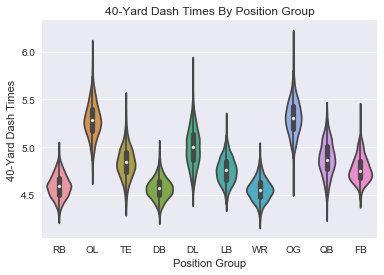

In [12]:
#Create a violinplot for 40 Yard dash times, grouped by position
forty_yard_df_pos = df_joined[['Pos', '40_Yard']].dropna()

sns.set()
_ = sns.violinplot('Pos', '40_Yard', data = forty_yard_df_pos)
_ = plt.xlabel('Position Group')
_ = plt.ylabel('40-Yard Dash Times')
_ = plt.title('40-Yard Dash Times By Position Group')
_ = plt.show()

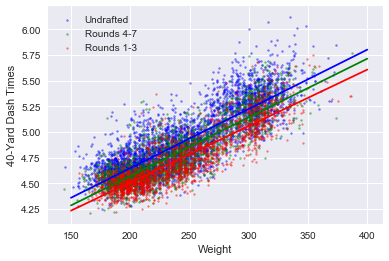

Regression for Undrafted: y =0.00577555345115x + 3.49133987383
Regression for Rounds 4-7: y =0.00572156087548x + 3.42500430497
Regression for Rounds 1-3: y =0.00549876171543x + 3.407507269


In [6]:
#Create a scatterplot of 40 yard dash times against weight, split by Round dimension (Undrafted, Rounds 4-7, Rounds 1-3)

forty_yard_df_weight_13 = df_joined[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_df_weight_13 = forty_yard_df_weight_13[forty_yard_df_weight_13['Rnd'] == '1-3']

forty_yard_df_weight_47 = df_joined[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_df_weight_47 = forty_yard_df_weight_47[forty_yard_df_weight_47['Rnd'] == '4-7']

forty_yard_df_weight_Undrafted = df_joined[['Weight', '40_Yard', 'Rnd']].dropna()
forty_yard_df_weight_Undrafted = forty_yard_df_weight_Undrafted[forty_yard_df_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,400])
m_Undrafted, b_Undrafted = np.polyfit(forty_yard_df_weight_Undrafted['Weight'], forty_yard_df_weight_Undrafted['40_Yard'], deg=1)
m_47, b_47 = np.polyfit(forty_yard_df_weight_47['Weight'], forty_yard_df_weight_47['40_Yard'], deg=1)
m_13, b_13 = np.polyfit(forty_yard_df_weight_13['Weight'], forty_yard_df_weight_13['40_Yard'], deg=1)


#plotting regression lines
_ = plt.plot(x, m_Undrafted*x + b_Undrafted, color = 'blue')
_ = plt.plot(x, m_47*x + b_47, color = 'green')
_ = plt.plot(x, m_13*x + b_13, color = 'red')

#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', '40_Yard', data = forty_yard_df_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', '40_Yard', data = forty_yard_df_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', '40_Yard', data = forty_yard_df_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight')
_ = plt.ylabel('40-Yard Dash Times')
_ = plt.title('40-Yard Dash Performances By Weight')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y =' + str(m_Undrafted) + 'x + ' + str(b_Undrafted))
print('Regression for Rounds 4-7: y =' + str(m_47) + 'x + ' + str(b_47))
print('Regression for Rounds 1-3: y =' + str(m_13) + 'x + ' + str(b_13))

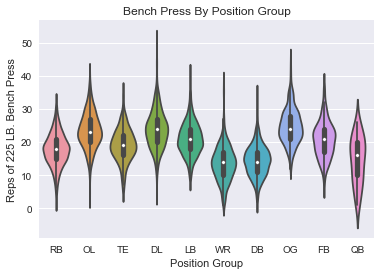

In [11]:
#Create a violinplot for bench press, grouped by position
bench_press_df_pos = df_joined[['Pos', 'Bench_Press']].dropna()

sns.set()
_ = sns.violinplot('Pos', 'Bench_Press', data = bench_press_df_pos)
_ = plt.xlabel('Position Group')
_ = plt.ylabel('Reps of 225 LB. Bench Press')
_ = plt.title('Bench Press By Position Group')
_ = plt.show()

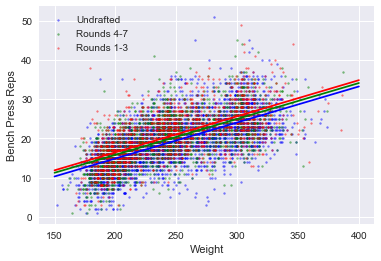

Regression for Undrafted: y =0.00577555345115x + 3.49133987383
Regression for Rounds 4-7: y =0.00572156087548x + 3.42500430497
Regression for Rounds 1-3: y =0.00549876171543x + 3.407507269


In [10]:
#Create a scatterplot of bench presses against weight, split by Round dimension (Undrafted, Rounds 4-7, Rounds 1-3)

bench_press_weight_13 = df_joined[['Weight', 'Bench_Press', 'Rnd']].dropna()
bench_press_weight_13 = bench_press_weight_13[bench_press_weight_13['Rnd'] == '1-3']

bench_press_weight_47 = df_joined[['Weight', 'Bench_Press', 'Rnd']].dropna()
bench_press_weight_47 = bench_press_weight_47[bench_press_weight_47['Rnd'] == '4-7']

bench_press_weight_Undrafted = df_joined[['Weight', 'Bench_Press', 'Rnd']].dropna()
bench_press_weight_Undrafted = bench_press_weight_Undrafted[bench_press_weight_Undrafted['Rnd'] == 'Undrafted']


#calculate regression lines for all 3 groups
x = np.array([150,400])
m_bp_Undrafted, b_bp_Undrafted = np.polyfit(bench_press_weight_Undrafted['Weight'], bench_press_weight_Undrafted['Bench_Press'], deg=1)
m_bp_47, b_bp_47 = np.polyfit(bench_press_weight_47['Weight'], bench_press_weight_47['Bench_Press'], deg=1)
m_bp_13, b_bp_13 = np.polyfit(bench_press_weight_13['Weight'], bench_press_weight_13['Bench_Press'], deg=1)


#plotting regression lines
_ = plt.plot(x, m_bp_Undrafted*x + b_bp_Undrafted, color = 'blue')
_ = plt.plot(x, m_bp_47*x + b_bp_47, color = 'green')
_ = plt.plot(x, m_bp_13*x + b_bp_13, color = 'red')

#scatterplots in different colors for different round groups
blue = plt.scatter('Weight', 'Bench_Press', data = bench_press_weight_Undrafted, color = 'b', marker='.', alpha = 0.5, s=15)
green = plt.scatter('Weight', 'Bench_Press', data = bench_press_weight_47, color = 'g', marker='.', alpha = 0.5, s=15)
red = plt.scatter('Weight', 'Bench_Press', data = bench_press_weight_13, color = 'r', marker='.', alpha = 0.5, s=13)
_ = plt.xlabel('Weight')
_ = plt.ylabel('Bench Press Reps')
plt.legend([blue, green, red], ['Undrafted', 'Rounds 4-7', 'Rounds 1-3'])

plt.show()

#print regression formulas
print('Regression for Undrafted: y =' + str(m_Undrafted) + 'x + ' + str(b_Undrafted))
print('Regression for Rounds 4-7: y =' + str(m_47) + 'x + ' + str(b_47))
print('Regression for Rounds 1-3: y =' + str(m_13) + 'x + ' + str(b_13))